In [1]:

import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import argparse
import pandas as pd

import ray
ray.init()
from ray import tune


from neuralforecast.auto import AutoNHITS, AutoHEncoder
from neuralforecast.core import NeuralForecast

from neuralforecast.losses.pytorch import MAE, HuberLoss, MQLoss
from neuralforecast.losses.numpy import mae, mse

# from datasetsforecast.long_horizon import LongHorizon, LongHorizonInfo
from datasetsforecast.long_horizon2 import LongHorizon2, LongHorizon2Info

import logging

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
input_size = 512
horizon = 720
dataset = "ETTh1"

Y_df = LongHorizon2.load(directory="./data/", group=dataset)
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
freq = LongHorizon2Info[dataset].freq
val_size = LongHorizon2Info[dataset].val_size
test_size = LongHorizon2Info[dataset].test_size

epochs = 100
num_samples = 20
# Adapt input_size to available data
input_size = tune.choice([512])

#### 1. 定义搜索空间
mix_config = {
    "h": None,
    
    ### transformer:
    "former_hidden_size": tune.choice([32, 64]), 
    "former_linear_size": tune.choice([64, 256]), # 倾向于大
    "former_heads": tune.choice([4, 8]), 
    "former_encoder_layers": tune.choice([1, 3]),
    "former_dropout": tune.choice([0, 0.2, 0.6]),
    
    ### mlp:
    "mlp_block_layers": tune.choice([1, 3]),
    "mlp_blocks": tune.choice([1]),
    "mlp_hidden_size": tune.choice([64, 128]),   # 倾向于大
    "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [4, 2, 1]]), # 倾向于大
    "n_pool_kernel_size": tune.choice([[2, 2, 1], [8, 4, 1], [16, 8, 1]]), # 倾向于大
    "mlp_dropout": tune.choice([0, 0.2, 0.6]), # 倾向于大
    "attn_dropout": tune.choice([0, 0.2, 0.6]), # 倾向于大
    
    ### basic:
    "learning_rate": tune.loguniform(1e-4, 5e-3),  # 0.0027
    "loss": None,
    "input_size": input_size,
    "random_seed": tune.randint(1, 20),
    "val_check_steps": tune.choice([100]),
    "batch_size": tune.choice([32]),
    "windows_batch_size": tune.choice([32]),
    "scaler_type": tune.choice([None, "robust", "standard"]),  # None
} 

#### 2. 选择搜索算法
from ray.tune.search.optuna import OptunaSearch

#### 3. 确定模型
hencoder = AutoHEncoder(
        h=horizon,
        loss=MAE(),
        config=mix_config,
        num_samples=num_samples,
        search_alg=OptunaSearch(),
        refit_with_val=True,
    )

nf = NeuralForecast(models=[hencoder], freq=freq)
# Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)
nf.fit(df=Y_df, val_size=val_size)


(_train_tune pid=2008) Global seed set to 17


(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 430378
(_train_tune pid=2008) tst编码器的参数量： 151747
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.34it/s, v_num=0, train_loss_step=0.580, train_loss_epoch=0.684]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=2008) Global seed set to 7


(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s, v_num=0, train_loss_step=0.580, train_loss_epoch=0.580, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) mlp编码器的参数量： 239468
(_train_tune pid=2008) tst编码器的参数量： 9441
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.55it/s, v_num=0, train_loss_step=1.010, train_loss_epoch=1.350]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s, v_num=0, train_loss_step=1.010, train_loss_epoch=1.010, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking: 0it [00:00, ?it/s] 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=2008) Global seed set to 11


(_train_tune pid=2008) mlp编码器的参数量： 582698
(_train_tune pid=2008) tst编码器的参数量： 27009
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.30it/s, v_num=0, train_loss_step=2.000, train_loss_epoch=1.740]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=2008) Global seed set to 16


(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, v_num=0, train_loss_step=2.000, train_loss_epoch=2.000, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 252018
(_train_tune pid=2008) tst编码器的参数量： 21921
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.36it/s, v_num=0, train_loss_step=1.490, train_loss_epoch=1.630]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s, v_num=0, train_loss_step=1.490, train_loss_epoch=1.490, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) mlp编码器的参数量： 529450
(_train_tune pid=2008) tst编码器的参数量： 26531


(_train_tune pid=2008) Global seed set to 17


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s, v_num=0, train_loss_step=0.559, train_loss_epoch=0.664]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, v_num=0, train_loss_step=0.559, train_loss_epoch=0.559, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 229034
(_train_tune pid=2008) tst编码器的参数量： 9441


(_train_tune pid=2008) Global seed set to 9


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.64it/s, v_num=0, train_loss_step=1.000, train_loss_epoch=0.791]
Validation: 0it [00:00, ?it/s]0m 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s, v_num=0, train_loss_step=1.000, train_loss_epoch=1.000, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=2008) Global seed set to 11


(_train_tune pid=2008) mlp编码器的参数量： 582698
(_train_tune pid=2008) tst编码器的参数量： 27009
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.66it/s, v_num=0, train_loss_step=1.770, train_loss_epoch=1.600]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, v_num=0, train_loss_step=1.770, train_loss_epoch=1.770, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 640748
(_train_tune pid=2008) tst编码器的参数量： 63971


(_train_tune pid=2008) Global seed set to 19


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.02it/s, v_num=0, train_loss_step=1.450, train_loss_epoch=1.810]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, v_num=0, train_loss_step=1.450, train_loss_epoch=1.450, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking: 0it [00:00, ?it/s] 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=2008) Global seed set to 10


(_train_tune pid=2008) mlp编码器的参数量： 435442
(_train_tune pid=2008) tst编码器的参数量： 151747
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.87it/s, v_num=0, train_loss_step=0.805, train_loss_epoch=1.040]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s, v_num=0, train_loss_step=0.805, train_loss_epoch=0.805, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed


(_train_tune pid=2008) Global seed set to 4


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 231538
(_train_tune pid=2008) tst编码器的参数量： 27009
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.29it/s, v_num=0, train_loss_step=0.662, train_loss_epoch=0.635]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s, v_num=0, train_loss_step=0.662, train_loss_epoch=0.635, valid_loss=6.52e+4]
                                                                      
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.78it/s, v_num=0, train_loss_step=0.662, train_loss_epoch=0.662, valid_loss=6.52e+4]


(_train_tune pid=2008) Global seed set to 17


(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) mlp编码器的参数量： 483626
(_train_tune pid=2008) tst编码器的参数量： 9441
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.31it/s, v_num=0, train_loss_step=1.710, train_loss_epoch=1.910]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, v_num=0, train_loss_step=1.710, train_loss_epoch=1.710, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 206578
(_train_tune pid=2008) tst编码器的参数量： 27009


(_train_tune pid=2008) Global seed set to 2


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 30.23it/s, v_num=0, train_loss_step=0.582, train_loss_epoch=0.559]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=2008) Global seed set to 2


(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s, v_num=0, train_loss_step=0.582, train_loss_epoch=0.582, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 231538
(_train_tune pid=2008) tst编码器的参数量： 77443
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.85it/s, v_num=0, train_loss_step=0.534, train_loss_epoch=0.529]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s, v_num=0, train_loss_step=0.534, train_loss_epoch=0.534, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed


(_train_tune pid=2008) Global seed set to 1


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 206578
(_train_tune pid=2008) tst编码器的参数量： 27009
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.73it/s, v_num=0, train_loss_step=0.625, train_loss_epoch=0.750]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s, v_num=0, train_loss_step=0.625, train_loss_epoch=0.625, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=2008) Global seed set to 1


(_train_tune pid=2008) mlp编码器的参数量： 206578
(_train_tune pid=2008) tst编码器的参数量： 27009
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 28.57it/s, v_num=0, train_loss_step=0.630, train_loss_epoch=0.768]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s, v_num=0, train_loss_step=0.630, train_loss_epoch=0.630, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 206578
(_train_tune pid=2008) tst编码器的参数量： 27009


(_train_tune pid=2008) Global seed set to 3


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 30.17it/s, v_num=0, train_loss_step=0.649, train_loss_epoch=0.626]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=2008) Global seed set to 5


(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s, v_num=0, train_loss_step=0.649, train_loss_epoch=0.649, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 206578
(_train_tune pid=2008) tst编码器的参数量： 27009
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 30.17it/s, v_num=0, train_loss_step=0.761, train_loss_epoch=0.630]
Validation: 0it [00:00, ?it/s]0m 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s, v_num=0, train_loss_step=0.761, train_loss_epoch=0.761, valid_loss=6.52e+4]


(_train_tune pid=2008) Global seed set to 6


(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 206578
(_train_tune pid=2008) tst编码器的参数量： 27009
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.25it/s, v_num=0, train_loss_step=0.714, train_loss_epoch=0.734]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=2008) Global seed set to 1


(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s, v_num=0, train_loss_step=0.714, train_loss_epoch=0.714, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) mlp编码器的参数量： 239468
(_train_tune pid=2008) tst编码器的参数量： 27009
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.82it/s, v_num=0, train_loss_step=0.667, train_loss_epoch=0.811]
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2008) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s, v_num=0, train_loss_step=0.667, train_loss_epoch=0.667, valid_loss=6.52e+4]
(_train_tune pid=2008) 16-mixed
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 239468
(_train_tune pid=2008) tst编码器的参数量： 51777


(_train_tune pid=2008) Global seed set to 1


Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.778, train_loss_epoch=0.778]        


Global seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.92it/s, v_num=0, train_loss_step=0.718, train_loss_epoch=0.908]
Validation: 0it [00:00, ?it/s]0m 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s, v_num=0, train_loss_step=0.718, train_loss_epoch=0.908, valid_loss=6.52e+4]
                                                                      
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s, v_num=0, train_loss_step=0.718, train_loss_epoch=0.718, valid_loss=6.52e+4]
best config: {'h': 720, 'former_hidden_size': 64, 'former_linear_size': 64, 'former_heads': 8, 'former_encoder_layers': 1, 'former_dropout': 0.2, 'mlp_block_layers': 1, 'mlp_blocks': 1, 'mlp_hidden_size': 64, 'n_freq_downsample': [168, 24, 1], 'n_pool_kernel_size': [8, 4, 1], 'mlp_dropout': 0, 'attn_dropout': 0.2, 'learning_rate': 0.0010410334467141978, 'loss': MAE(), 'input_size': 512, 'random_seed': 1, 'val_check_steps': 100, 'batch_size': 32, 'windows_batch_size': 32, 'scaler_type': None, 'valid_loss': MAE()}
1

In [2]:
savepath:str = os.path.join('checkpoints',dataset+str(horizon))
nf.save(path=savepath,
        model_index=None, 
        overwrite=True,
        save_dataset=True)

In [2]:
from neuralforecast import NeuralForecast
# nf = NeuralForecast.load(path='./checkpoints/TrafficL96/')
nf = NeuralForecast.load(path='./checkpoints/ETTh196/')

Y_hat_insample = nf.predict_insample(step_size=96)

Global seed set to 1


2018-02-20 23:00:00 14400 <Hour>
16-mixed
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]mlp编码器的参数量： 1940581
tst编码器的参数量： 38689
Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


<Axes: xlabel='ds'>

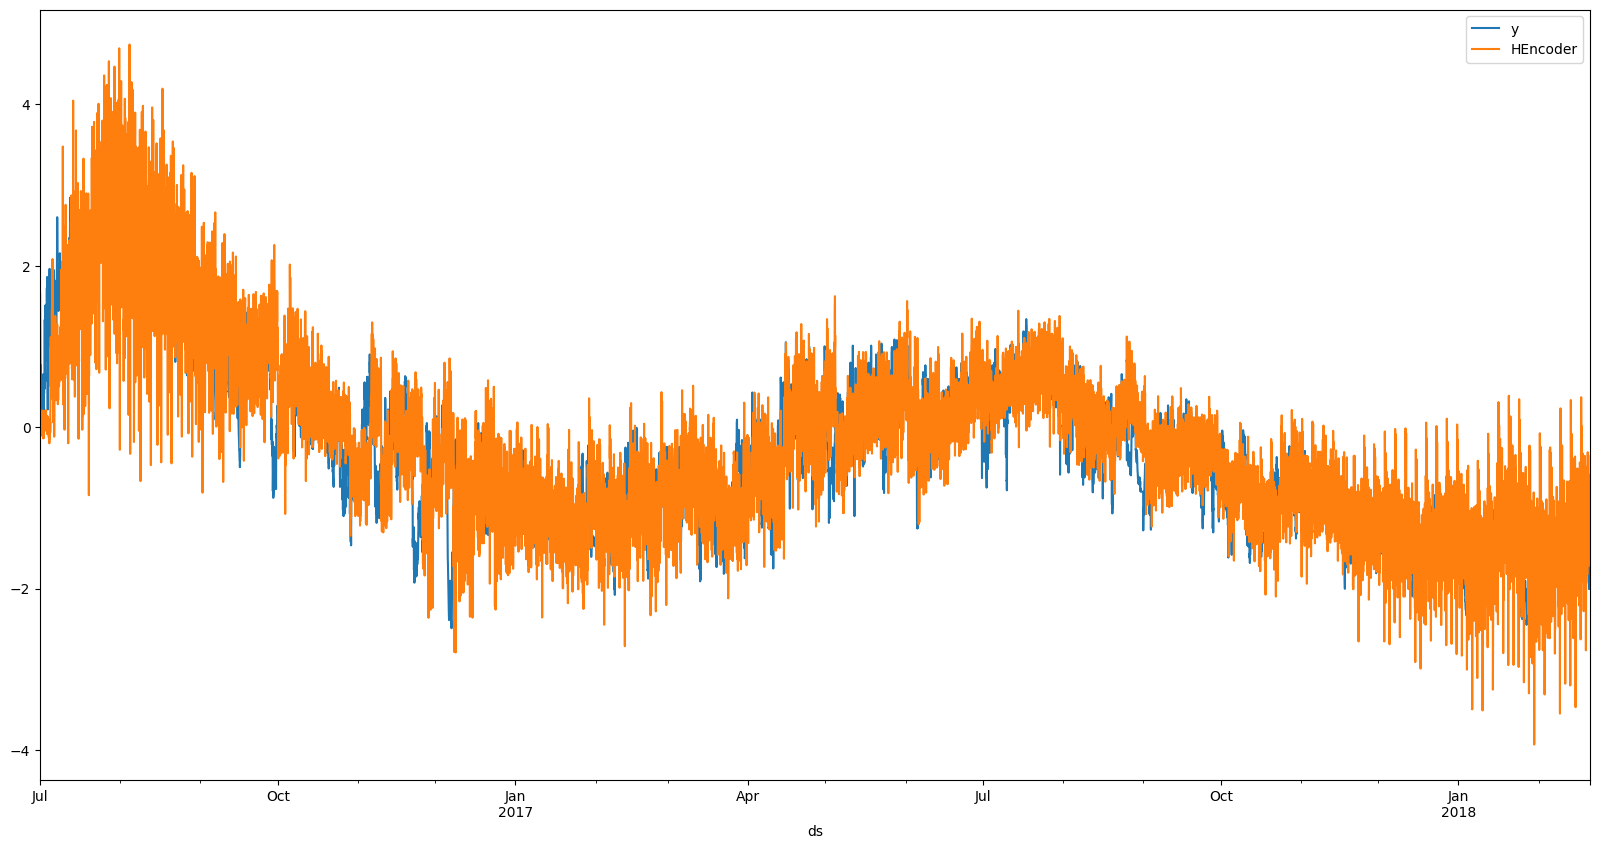

In [3]:
import matplotlib.pyplot as plt
OT = Y_hat_insample.loc[Y_hat_insample['unique_id']=='OT']
OT.plot(x='ds', y=['y','HEncoder'], figsize=(20, 10))

In [5]:
from neuralforecast.losses.numpy import mae, mse
horizon = 96
dataset = "TrafficL"
Y_hat_df = Y_hat_insample
y_true = Y_hat_df.y.values
y_hat = Y_hat_df["HEncoder"].values
n_series = len(Y_hat_df.unique_id.unique())
y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)
print("\n" * 4)
print("Parsed results")
print(f"HEncoder {dataset} h={horizon}")
# print("test_size", test_size)
print("y_true.shape (n_series, n_windows, n_time_out):\t", y_true.shape)
print("y_hat.shape  (n_series, n_windows, n_time_out):\t", y_hat.shape)
# print(' best validation hyperparameter:\t', nf.models[0].results.get_best_result().config)
print("MSE: ", mse(y_hat, y_true))
print("MAE: ", mae(y_hat, y_true))







Parsed results
HEncoder TrafficL h=96
y_true.shape (n_series, n_windows, n_time_out):	 (7, 150, 96)
y_hat.shape  (n_series, n_windows, n_time_out):	 (7, 150, 96)
MSE:  0.7229357
MAE:  0.6251821
